In [534]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
import gc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [535]:

TRAIN_PATH = 'train.csv'
TEST_PATH = 'test.csv'


df = pd.read_csv(TRAIN_PATH)
X_final = pd.read_csv(TEST_PATH)

In [536]:

X = df.drop('Survived', axis=1)
y = df[['Survived']]
X.set_index('PassengerId', inplace=True)
X_final.set_index('PassengerId', inplace=True)

print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', X_final.shape[0])


Строк в трейне: 891
Строк в тесте 418


c:\users\daneeeek\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


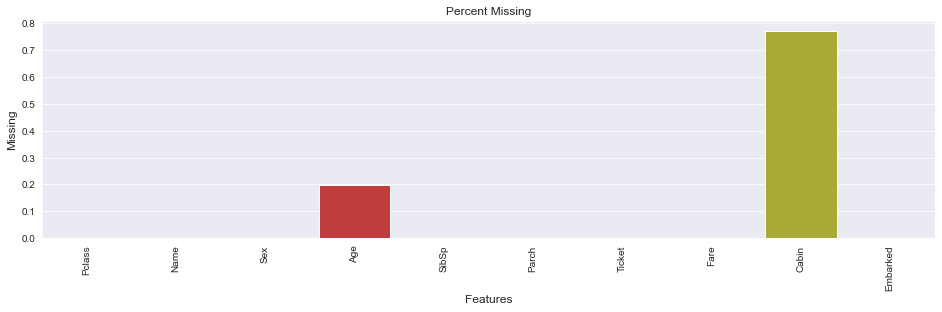

In [537]:
nan_df = (X.isna().sum() / X.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']

plt.figure(figsize=(16,4))
sns.barplot(nan_df['feature'], nan_df['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [538]:
# pal = dict(male="#6495ED", female="#F08080")
# 
# g = sns.lmplot(x="Fare", y="Survived", col="Sex", hue="Sex", data=df,
#                palette=pal, y_jitter=.02, logistic=True, truncate=False)
# g.set(xlim=(0, 300), ylim=(-.05, 1.05))
# 
# g2 = sns.lmplot(x="Age", y="Survived", col="Sex", hue="Sex", data=df,
#                palette=pal, y_jitter=.02, logistic=True, truncate=False)
# g2.set(xlim=(0, 80), ylim=(-.05, 1.05))
# 
# g2 = sns.lmplot(x="SibSp", y="Survived", col="Sex", hue="Sex", data=df,
#                palette=pal, y_jitter=.02, logistic=True, truncate=False)
# g2.set(xlim=(0, 10), ylim=(-.05, 1.05))
# g2.savefig('Rodnie.png')
# 
# 
# X['Age'].max()


In [539]:

# g3 = sns.scatterplot(x="Age", y="Fare",
#              hue="Sex",
#              data=df,)
# g3.figure.savefig('Bilti.png', dpi=400)
# 
# g4 = sns.lmplot(x="Age", y="Fare", col="Sex", hue="Sex", data=df,
#                palette=pal, y_jitter=.02, truncate=False)
# g4.savefig('Age-Fare.png', dpi=400)
# 
# g5 = sns.lmplot(x="Pclass", y="Survived", col="Sex", hue="Sex", data=df,
#                palette=pal, y_jitter=.02, truncate=False)

In [540]:
# 109/577 m 233 /314

female = df.loc[df['Sex'] == 'female']
male = df.loc[df['Sex'] == 'male']
male_surv = round(len(male.loc[male['Survived'] == 1]) / len(male) * 100, 2)
female_surv = round(len(female.loc[female['Survived'] == 1]) / len(female) * 100, 2)
surv = round(len(df.loc[df['Survived'] == 1]) / len(df), 2)
print(f'Overall survived {surv}%\nMen survived     {male_surv}%\nWomen survived   {female_surv}%')



Overall survived 0.38%
Men survived     18.89%
Women survived   74.2%


In [541]:

class FeaturesImputer():
    """ Заполнение пропусков и обработка выбросов """
    def __init__(self):
        self.medians=None
        self.mode=None
        self.male_medians=None
        self.female_medians=None
        
    def fit(self, X):
        
        self.medians = X.median()
        self.mode = X.mode()
        self.male_medians = X.loc[X['Sex'] == 'male'].median()
        self.female_medians = X.loc[X['Sex'] == 'female'].median()
        
    def transform(self, X):
        
        if 'Cabin' in X.columns:
            X.drop('Cabin', axis=1, inplace=True)
            
        X['Age_outlier'] = 0
        X.loc[X['Age'].isna(), 'Age_outlier'] = 1
        #X.loc[X['Age'].isna(), 'Age'] = self.medians['Age']
        X.loc[(X['Age'].isna()) & (X['Sex'] == 'male'), 'Age'] = self.male_medians['Age']
        X.loc[(X['Age'].isna()) & (X['Sex'] == 'female'), 'Age'] = self.female_medians['Age']
        
        X['Fare_outlier'] = 0
        X.loc[X['Fare'].isna(), 'Fare_outlier'] = 1
        X.loc[X['Fare'].isna(), 'Fare'] = self.medians['Fare']
        
        
        
        return X

In [542]:

class FeaturesGenerator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.kek = None
    
    def fit(self, X):
        self.todo = 'ok'
        
        
    def transform(self, X):
        
        #Категоризация признаков
        
        X = self.pclass_to_cat(X)
        X = self.embarked_to_cat(X)
        X = self.sex_to_cat(X)
        
        # Если у пассажира есть родственники, то IsAlone = 0
        X['Is_Alone'] = 1
        X.loc[(X['SibSp'] > 0) & (X['Parch'] > 0), 'Is_Alone'] = 0
        
        #
        X['With_Nanny'] = 0
        X.loc[(X['Age'] < 14) & (X['Parch'] == 0), 'With_Nanny'] = 1
        
        
        # X['Age/Fare'] = 0
        # X.loc[X['Fare'] != 0, 'Age/Fare'] = X['Age'] / X['Fare'] ухудшается скор
        
        
    
    @staticmethod
    def sex_to_cat(X):
        X['cat_Male'] = 0
        X['cat_Female'] = 0
        X.loc[X['Sex'] == 'male', 'cat_Male'] = 1
        X.loc[X['Sex'] == 'female', 'cat_Female'] = 1
        X['cat_Male'] = X['cat_Male'].fillna(0)
        X['cat_Female'] = X['cat_Female'].fillna(0)
        return X
        
    @staticmethod 
    def pclass_to_cat(X):
        X['cat_Pclass_1'] = 0
        X['cat_Pclass_2'] = 0
        X['cat_Pclass_3'] = 0
        X.loc[X['Pclass'] == 1, 'cat_Pclass_1'] = 1
        X.loc[X['Pclass'] == 2, 'cat_Pclass_2'] = 1
        X.loc[X['Pclass'] == 3, 'cat_Pclass_3'] = 1
        return X
        
    @staticmethod
    def embarked_to_cat(X):
        X['cat_Embarked_Cherbourg'] = 0
        X['cat_Embarked_Queenstown'] = 0
        X['cat_Embarked_Southampton'] = 0
        X.loc[X['Embarked'] == 'C', 'cat_Embarked_Cherbourg'] = 1
        X.loc[X['Embarked'] == 'Q', 'cat_Embarked_Queenstown'] = 1
        X.loc[X['Embarked'] == 'S', 'cat_Embarked_Southampton'] = 1
        
        return X



In [543]:
fix_data = FeaturesImputer()
features = FeaturesGenerator()
fix_data.fit(X)
fix_data.transform(X)
features.transform(X)
fix_data.transform(X_final)
features.transform(X_final)


X_final.isna().sum()

Pclass                      0
Name                        0
Sex                         0
Age                         0
SibSp                       0
Parch                       0
Ticket                      0
Fare                        0
Embarked                    0
Age_outlier                 0
Fare_outlier                0
cat_Pclass_1                0
cat_Pclass_2                0
cat_Pclass_3                0
cat_Embarked_Cherbourg      0
cat_Embarked_Queenstown     0
cat_Embarked_Southampton    0
cat_Male                    0
cat_Female                  0
Is_Alone                    0
With_Nanny                  0
dtype: int64

In [544]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [545]:
X_train

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_outlier,...,cat_Pclass_1,cat_Pclass_2,cat_Pclass_3,cat_Embarked_Cherbourg,cat_Embarked_Queenstown,cat_Embarked_Southampton,cat_Male,cat_Female,Is_Alone,With_Nanny
PassengerId,,,,,,,,,,,,,,,,,,,,,
332,1,"Partner, Mr. Austen",male,45.5,0,0,113043,28.5000,S,0,...,1,0,0,0,0,1,1,0,1,0
734,2,"Berriman, Mr. William John",male,23.0,0,0,28425,13.0000,S,0,...,0,1,0,0,0,1,1,0,1,0
383,3,"Tikkanen, Mr. Juho",male,32.0,0,0,STON/O 2. 3101293,7.9250,S,0,...,0,0,1,0,0,1,1,0,1,0
705,3,"Hansen, Mr. Henrik Juul",male,26.0,1,0,350025,7.8542,S,0,...,0,0,1,0,0,1,1,0,1,0
814,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,S,0,...,0,0,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,3,"Salkjelsvik, Miss. Anna Kristine",female,21.0,0,0,343120,7.6500,S,0,...,0,0,1,0,0,1,0,1,1,0
271,1,"Cairns, Mr. Alexander",male,29.0,0,0,113798,31.0000,S,1,...,1,0,0,0,0,1,1,0,1,0
861,3,"Hansen, Mr. Claus Peter",male,41.0,2,0,350026,14.1083,S,0,...,0,0,1,0,0,1,1,0,1,0


In [546]:




X_columns = ['Age', 'SibSp', 'Parch', 'Fare',
       'cat_Male', 'cat_Female', 'cat_Pclass_1', 'cat_Embarked_Cherbourg', 'cat_Embarked_Southampton', 'cat_Embarked_Queenstown', 
       'cat_Pclass_2', 'cat_Pclass_3',  'Is_Alone', 'With_Nanny']



X_train, X_test, X, X_final = X_train[X_columns], X_test[X_columns], X[X_columns], X_final[X_columns]





In [547]:
n_estimators = [int(x) for x in np.linspace(1,25,5)]
max_depth = [6,8,10,12]
min_samples_split = [2,5,10,15]
min_samples_leaf = [1,2,4,8,16]
max_features = [0.33, 'sqrt', 'log2']
bootstrap = [True, False]
random_state = [42]

param_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf' : min_samples_leaf,
    'max_features' : max_features,
    'bootstrap' : bootstrap,
    'random_state' : random_state
}



rf_Grid = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, cv = 3, verbose=2, n_jobs = 4)
#rf_Grid.fit(X_train, y)
#rf_Grid.best_params_

In [548]:

model = RandomForestClassifier(bootstrap=False, max_depth=8, max_features=0.33,
                       min_samples_split=5, n_estimators=10, random_state=42)

In [549]:
# 0.7737226277372262, 0.8301176792556104
model.fit(X_train, y_train)
y_pred = model.predict(X_test)



accuracy_score(y_test, y_pred)

<ipython-input-549-32e7f29f4833>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


0.8268156424581006

<AxesSubplot:>

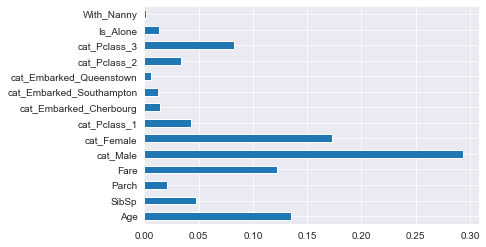

In [550]:
feat_importances = pd.Series(model.feature_importances_, index=X_columns)
feat_importances.plot(kind='barh')

In [551]:
model.fit(X, y)
y_final = model.predict(X_final)





idss = np.arange(892,1310)
ggggg = {
    'PassengerId': idss,
    'Survived': y_final
}
submit = pd.DataFrame(ggggg, columns =['PassengerId', 'Survived'])
submit.to_csv('preds.csv', index=False)
submit.head()





<ipython-input-551-430ed828abf2>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X, y)


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [552]:

def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
    
print_full(df['Ticket'].sort_values())

504                110152
257                110152
759                110152
262                110413
558                110413
585                110413
110                110465
475                110465
430                110564
366                110813
170                111240
462                111320
523                111361
329                111361
889                111369
604                111426
507                111427
187                111428
806                112050
633                112052
887                112053
815                112058
263                112059
209                112277
766                112379
711                113028
331                113043
536                113050
452                113051
857                113055
284                113056
83                 113059
782                113501
377                113503
166                113505
356                113505
54                 113509
351                113510
252         